___
# NN Training Study
## __By:__ José Luis Almendarez González

### Abstract

### Methodology

### Results

### Analysis

### Limitations

### References
___

### Python libraries *

In [4]:
import lib
from IPython.display import display

 \* Many of these libraries are properly referenced in the "lib.py", an imported document used for presentation.

### Data Import, Split, Augmentation & Preparation
___

In [ ]:
# train_data, test_data = lib.download_mnist_data()
# lib.create_directory_structure()
# lib.save_subset(train_data, './data/MNIST/use/original', n_per_class=60)
# lib.generate_augmented('./data/MNIST/use/original/train',
#                        './data/MNIST/use/augmented/train',
#                        target_count=432)
# lib.generate_augmented('./data/MNIST/use/original/test',
#                        './data/MNIST/use/augmented/test',
#                        target_count=108)

In [5]:
train_dataset, test_dataset = lib.create_train_test_datasets()

Train dataset size: 4800
Test dataset size: 1200
Total images: 6000


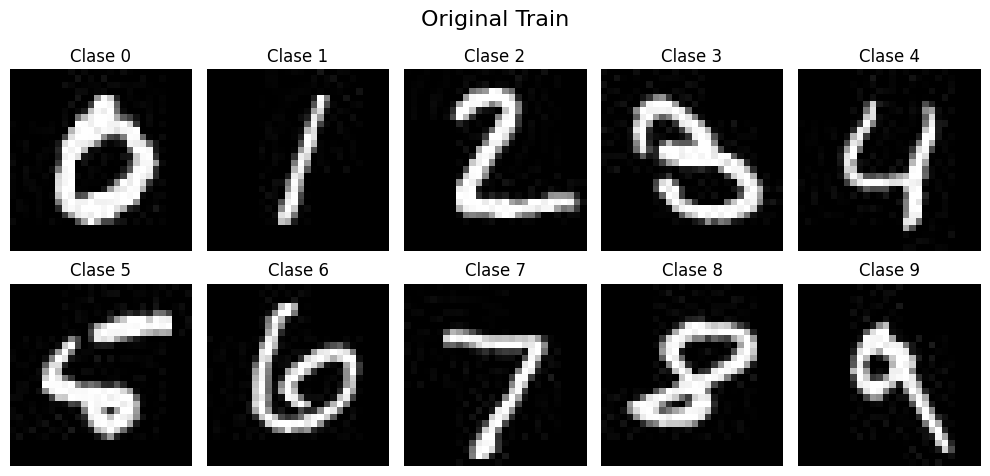

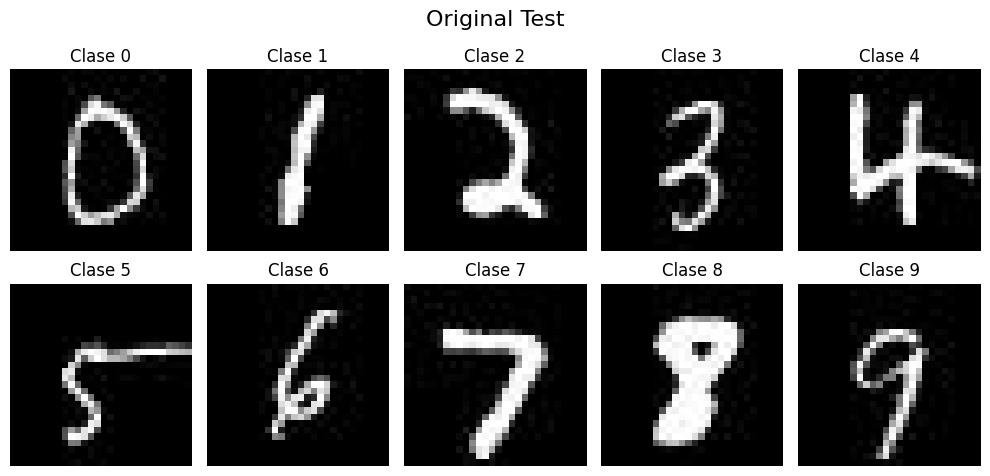

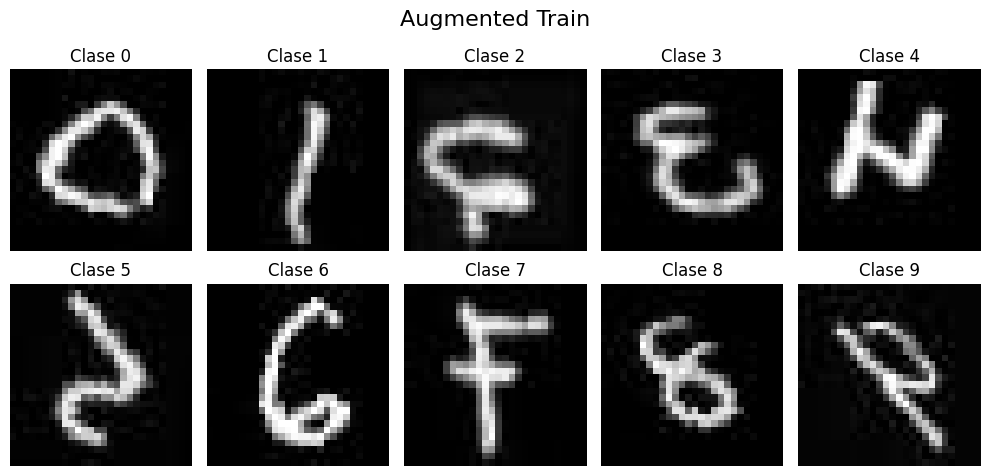

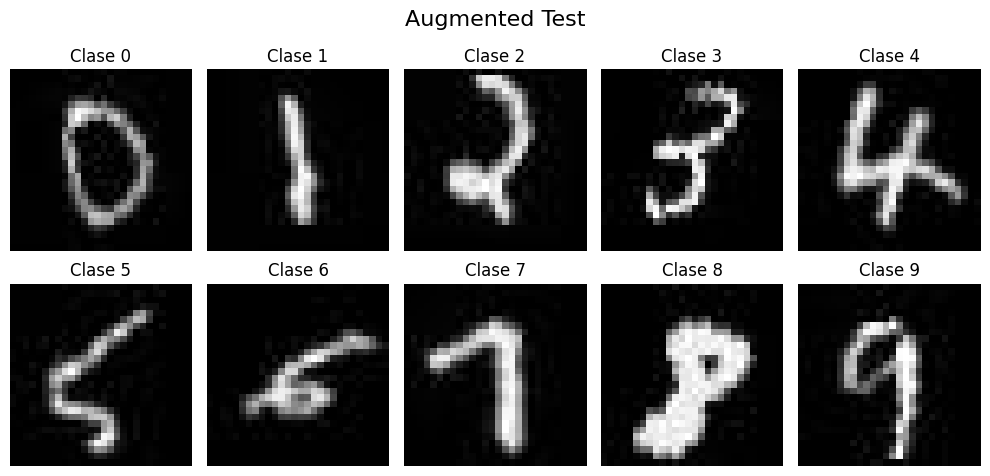

In [6]:
lib.plot_images('./data/MNIST/use/original/train', "Original Train")
lib.plot_images('./data/MNIST/use/original/test', "Original Test")

lib.plot_images('./data/MNIST/use/augmented/train', "Augmented Train")
lib.plot_images('./data/MNIST/use/augmented/test', "Augmented Test")

In [7]:
train_dataset, test_dataset

(<torch.utils.data.dataset.ConcatDataset at 0x11f68bf50>,
 <torch.utils.data.dataset.ConcatDataset at 0x12a603380>)

### Build & Evaluate Model(s)
___

In [8]:
ui = lib.create_training_ui(train_dataset, test_dataset)
display(ui)

___